In [2]:
import os
import pandas as pd

from itertools import chain
from utils import *
cols2keep=['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'VV', 'VH', 'label', 'date']
events = ['Invasion', 'Mowing 1st', 'Mowing 2nd', 'Waterlogging', 'Herbicide control', 'Recurring', 'No change']

In [9]:
# SH chongming North Samples     SH_2_317: Herbicide;   SH_13_401: Mowing
# SH Jiuduansha Samples          SH_10_451: Herbicide;  SH_11_243: Mowing
# ZJ HZB Samples                 ZJ_1_93: Herbicide;    ZJ_10_325: Mowing
# JS Sheyang Samples             JS_10_254: Herbicide;    ZJ_10_325: Mowing JS_10_254
samples_in_certrain_region = ['ZJ_10_325', 'ZJ_1_93'] # ZJ HZB
# samples_in_certrain_region = ['SH_2_317', 'SH_13_401']  # SH Chongming North
# samples_in_certrain_region = ['SH_10_451', 'SH_11_243'] 

# samples_in_certrain_region = ['JS_10_254', 'JS_1_307']    # Sheyang

# samples_in_certrain_region = [dir for dir in os.listdir('./samples') if dir.startswith('SH')]
required_sample_files = [proc_bands_value(sample_file, cols2keep=cols2keep) for sample_file in chain.from_iterable\
                        ([get_all_files_in_samples(f'.\\samples\\{folder}')[0] for folder in samples_in_certrain_region])]

herbicide_control_samples, mowing_control_samples = list(), list()
_date_herb, _date_mow = list(), list()
var2keep = ['NDVI', 'VV', 'VH', 'distance', 'date']

for sample_file in required_sample_files:
    dates, label = sample_file['date'].values, sample_file['label'].values
    change_points = np.where(label[:-1] != label[1:])[0] + 1

    cd = dates[np.concatenate([[0], change_points, [-1]])]
    lcc = label[np.concatenate([[0], change_points])] - 1
    for idx, lc in enumerate(lcc):
        if lc == 4: lcc[idx] = 3
        
    if len(lcc) == 1: continue
    output = extract_change_event_from_pixel(lcc, change_points)

    hped_event = [(event, output[i]) for i, event in enumerate(events) if output[i] != 99]
    hped_event = sorted(hped_event, key=lambda x: x[1])
    for event in hped_event:
        
        condition = (sample_file['date'] >= pd.Period('2023-01', freq='M')) & \
                    (sample_file['date'] <= pd.Period('2025-01', freq='M'))
                    
        sample_data = sample_file.loc[condition].copy()
        
        # check if hped in certain range
        # check if constrained to certain months
        is_hped_in_certain_range = sample_data['date'].isin([pd.Period(dates[event[1]], freq='M')]).any() 
        if not is_hped_in_certain_range: continue
        # if dates[event[1]] not in [pd.Period('2024-10', freq='M'), pd.Period('2023-12', freq='M'), pd.Period('2023-11', freq='M')]: continue
        
        # by distance
        if 'distance' in var2keep:
            control_date = event[1] - 1
            previous, last = 3, 3 # previous and last elements to keep
            sample_data = sample_file.iloc[control_date - previous: control_date + last + 1].copy()
            center_rel_idx = previous
            actual_center_idx = min(center_rel_idx, len(sample_data) - 1)
            sample_data['distance'] = [i - actual_center_idx for i in range(len(sample_data))]
        # calc NDVI
        sample_data['NDVI'] = (sample_data['B8'] - sample_data['B4']) / (sample_data['B8'] + sample_data['B4'])
        sample_data['LSWI'] = (sample_data['B11'] - sample_data['B8A']) / (sample_data['B11'] + sample_data['B8A'])
            
        
        
        sample_data = sample_data[var2keep]
        sample_data['distance'] = sample_data['distance'] - 1
        if event[0] == 'Herbicide control':
            herbicide_control_samples.append(sample_data)
            _date_herb.append(dates[event[1]])
        elif event[0] == 'Mowing 1st':
            # print('Mowing samples distance substract 1')
            # sample_data['distance'] = sample_data['distance'] + 1
            
            mowing_control_samples.append(sample_data)
            _date_mow.append(dates[event[1]])

herbicide_control_samples, mowing_control_samples = pd.concat(herbicide_control_samples).assign(type='Herbicide control'), \
                                                    pd.concat(mowing_control_samples).assign(type='Mowing')
from collections import Counter
print('\nHerb count:')
for date, count in Counter(_date_herb).items(): print(f'{date}: {count}')
print('Mowing count:')
for date, count in Counter(_date_mow).items(): print(f'{date}: {count}')



Herb count:
2023-10: 15
2023-09: 55
Mowing count:
2023-08: 194
2023-09: 5
2023-10: 9
2024-06: 1
2024-01: 1
2023-01: 1


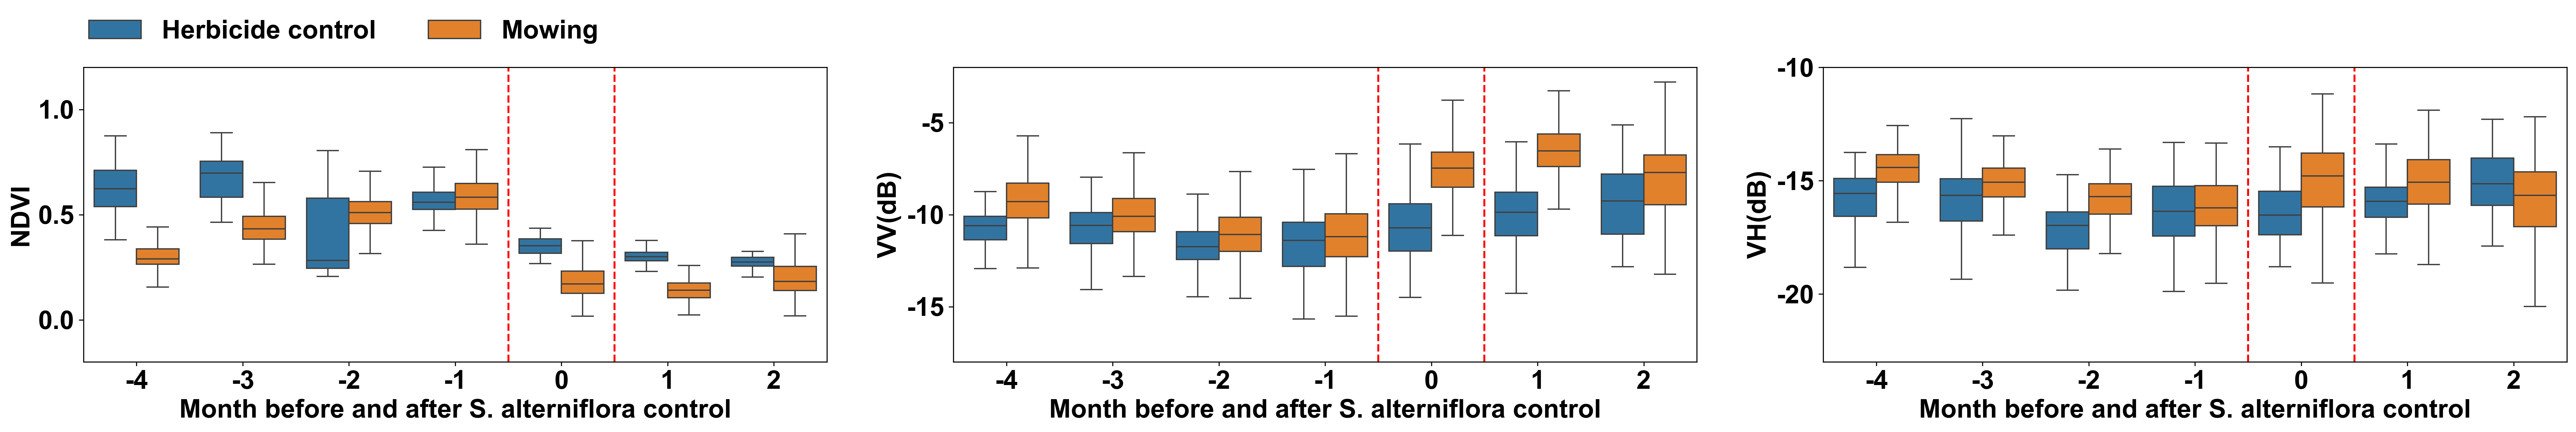

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.rcParams['font.family'] = ['Arial']
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 20

combined_data = pd.concat([herbicide_control_samples, mowing_control_samples], ignore_index=True)
combined_data['date'] = pd.to_datetime(combined_data['date'].astype(str)).dt.strftime('%Y-%b')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 5), dpi=300)
x_pron_position, which_is_x = 0, 'distance'
band_ylim = list([(-0.2, 1.2), (-18, -2), (-23, -10)]) # NDVI, VV, VH
for ax, label, y_lim in zip([ax1, ax2, ax3], ['NDVI', 'VV', 'VH'], band_ylim):
    ax.set_ylim(y_lim[0], y_lim[-1])
    sns.boxplot(data=combined_data, 
                x=which_is_x,
                # x='date', 
                y=label,
                hue='type',
                showfliers=False,
                ax=ax)

    ax.tick_params(axis='x', rotation=0 if which_is_x == 'distance' else 30, labelsize=20, length=3, labelbottom=True, which='major')
    ax.set_ylabel(label if label == 'NDVI' else label + '(dB)', fontweight='bold')
    ax.set_xlabel('Month before and after S. alterniflora control', fontweight='bold')
    
    if ax == ax1:
        legend = ax.get_legend()
        legend.set_title('')
        ax.legend(bbox_to_anchor=(0.35, 1.0),
                  loc='lower center',
                  ncol=2, frameon=False)
    else: ax.get_legend().remove()
    
    if which_is_x == 'distance': x_pron_position = combined_data['distance'].unique().tolist().index(0)
    else: x_pron_position = combined_data['date'].unique().tolist().index('2023-Sep')
    
    ax.axvline(x=x_pron_position - 0.5, 
               linestyle='--', alpha=1, zorder=0, linewidth=1.5,
               color='red')
    ax.axvline(x=x_pron_position + 0.5, 
               linestyle='--', alpha=1, zorder=0, linewidth=1.5,
               color='red')
plt.tight_layout()
plt.show()
